# Import the module

In [3]:
import tensorflow as tf
import sys, imageio, os
import keras
import seaborn as sns
sys.path.append("/Users/kai/Downloads/graduation/final_git/MasterThesis/src/")
from config import *
from model import *
from data_prepare import *
from plot import *

In [4]:
data_list_k = ["20221116_Plate21","20230109_Plate521","20230111_Plate521","20230113_Plate521","20230111_Plate493"]
data_list_f = ["varying_lum_and_focus_train","varying_lum_and_focus_test"]
X_train_k, y_train_k, X_test_k , y_test_k = combine_dataset(data_list_k,2)
X_train_f, y_train_f, X_test_f , y_test_f = combine_dataset(data_list_f,1)
X_train = np.concatenate([X_train_k,X_train_f], axis=0)
X_test  = np.concatenate ([X_test_k ,X_test_f] , axis=0)
y_train = np.concatenate([y_train_k,y_train_f], axis=0)
y_test  = np.concatenate ([y_test_k ,y_test_f] , axis=0)

In [5]:
X_train.shape, y_train.shape, X_test.shape, y_test.shape

((2543, 120), (2543, 1), (640, 120), (640, 1))

In [6]:
model = load_model()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling (Rescaling)       (None, 120, 1)            0         
                                                                 
 conv_1 (Conv1D)             (None, 101, 128)          2688      
                                                                 
 conv_2 (Conv1D)             (None, 91, 128)           180352    
                                                                 
 batch_normalization (BatchN  (None, 91, 128)          512       
 ormalization)                                                   
                                                                 
 dropout (Dropout)           (None, 91, 128)           0         
                                                                 
 flatten (Flatten)           (None, 11648)             0         
                                                        

2023-04-04 17:18:42.792504: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


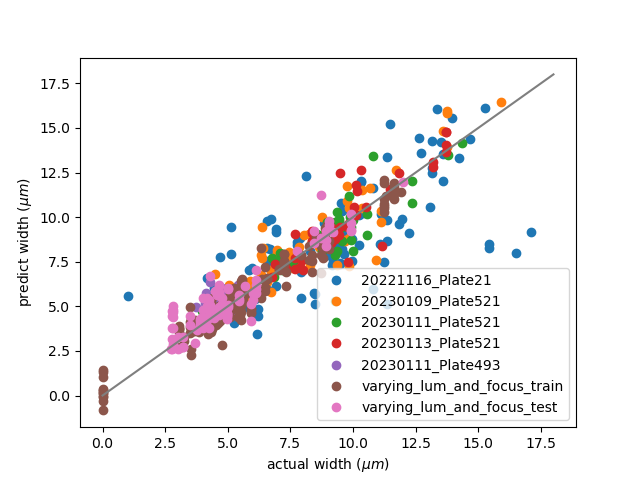

In [7]:
%matplotlib widget
for i in range(len(data_list_k)):
    plot_seperate_dataset(model,data_list_k[i],2,120)
for i in range(len(data_list_f)):
    plot_seperate_dataset(model,data_list_f[i],1,120)
plt.plot([0,18],[0,18])
plt.ylabel("predict width ($\mathit{\mu m}$)")
plt.xlabel("actual width ($\mathit{\mu m}$)")
plt.legend()

In [13]:
model_name_list = ["default_CNN_model"]
crop_value = [120]
model_list,learning_rate = load_model_list(model_name_list,model_path)

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling (Rescaling)       (None, 120, 1)            0         
                                                                 
 conv_1 (Conv1D)             (None, 101, 128)          2688      
                                                                 
 conv_2 (Conv1D)             (None, 91, 128)           180352    
                                                                 
 batch_normalization (BatchN  (None, 91, 128)          512       
 ormalization)                                                   
                                                                 
 dropout (Dropout)           (None, 91, 128)           0         
                                                                 
 flatten (Flatten)           (None, 11648)             0         
                                                        

In [14]:
ME = statistic_evaluate(model_list,X_test,y_test,crop_value,statistic_type="ME" ,n_iterations=1000,n_samples=30)
RE = statistic_evaluate(model_list,X_test,y_test,crop_value,statistic_type="RE" ,n_iterations=1000,n_samples=30)
MAE= statistic_evaluate(model_list,X_test,y_test,crop_value,statistic_type="MAE",n_iterations=1000,n_samples=30)

Get 423 time(s) 0 in label.
Get 391 time(s) 0 in label, so it will not include in the output.
Get 433 time(s) 0 in label.


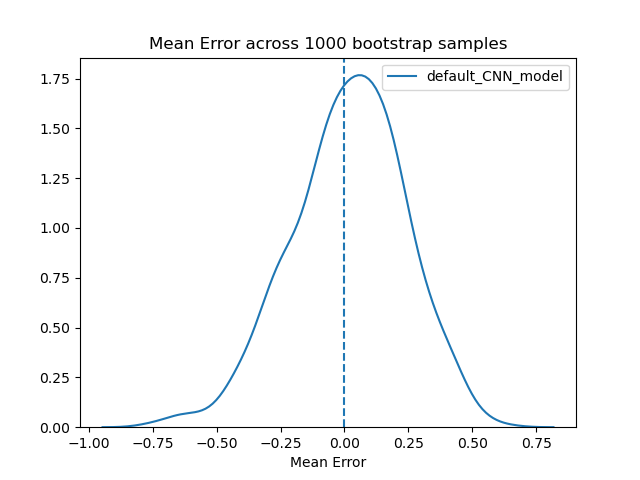

In [20]:
%matplotlib widget
for i in range(len(model_name_list)):
    sns.kdeplot(ME[i],label=model_name_list[i])
plt.title("Mean Error across 1000 bootstrap samples")
plt.axvline(0,linestyle="--")
plt.xlabel("Mean Error")
# plt.legend(bbox_to_anchor=(1.03, 1),loc='upper left')
plt.legend()

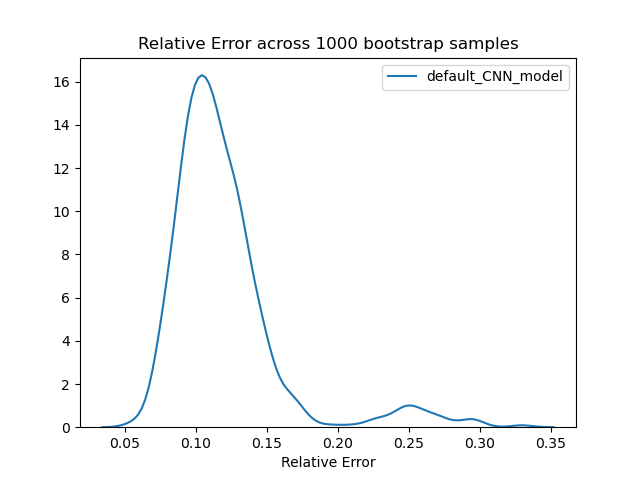

In [21]:
%matplotlib widget
for i in range(len(model_name_list)):
    sns.kdeplot(RE[i],label=model_name_list[i])
plt.title("Relative Error across 1000 bootstrap samples")
plt.xlabel("Relative Error")
# plt.legend(bbox_to_anchor=(1.03, 1),loc='upper left')
plt.legend()

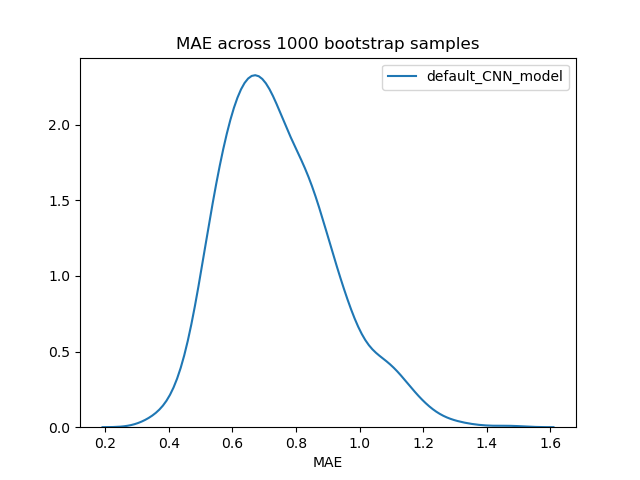

In [22]:
%matplotlib widget

for i in range(len(model_name_list)):
    sns.kdeplot(MAE[i],label=model_name_list[i])
plt.title("MAE across 1000 bootstrap samples")
plt.xlabel("MAE")
# plt.legend(bbox_to_anchor=(1.03, 1),loc='upper left')
plt.legend()

In [ ]:
def combine_dataset(data_list,value_size=1,test_size=0.2,random_state=42,shuffle=True):
    """
    combine several dataset together for training.
    
    data_list   : list, the folder name that you want to include them in the new dataset.
    value_size  : int, bin size of the data. For example, if the bin size is 2 you have to put 2 here as well.
                  Normally, the image size is 4096 × 3000. If it is resize to 2048 × 1500, you must put 2 instead of 1.
    test_size   : int, for split the training set and test set. Default is 0.2, the other o.8 for CV. 
                  If you do not use CV, you can change to 0.4 and split the test data again for validation. As the ratio of 0.6,0.2,0.2.
    random_state: int, pass an int for reproducible output 
    shuffle     : boolen, whether or not to shuffle the data before splitting.
    
    return      : array, feature for training
                  array, label for training
                  array, feature for testing
                  array, label for testing
    """
    X_train_list, y_train_list = [],[]
    X_test_list , y_test_list  = [],[]
    for dataset in data_list:
        X, y = data(dataset)
        y = y * value_size
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=random_state,shuffle=shuffle)
        X_train_list.extend(X_train), y_train_list.extend(y_train)
        X_test_list.extend(X_test), y_test_list.extend(y_test)
    X_train_list, y_train_list, X_test_list , y_test_list = np.array(X_train_list), np.array(y_train_list), np.array(X_test_list) , np.array(y_test_list)
    return X_train_list, y_train_list, X_test_list , y_test_list

def plot_seperate_dataset(model,dataset:str,value_size:int,crop_value:int):
    """
    to plot the dataset seperately
    
    model     : object, the model you want to check the performance
    dataset   : str, the dataset you want to check
    value_size: int, if you set the bin to 2, must set it as 2
    crop_value: int, for central or random cropping
    
    return    : object, plt for plotting.
    
    Notice    : x-axis is actual, y-axis is prediction
    """
    X, y = data(dataset)
    y = y * value_size
    X_train_iter, X_test_iter, y_train_iter, y_test_iter = train_test_split(X, y, test_size=0.2, random_state=42, shuffle=True)
    X_test = data_preparation(X_test_iter,crop_value)
    plt.plot(y_test_iter,model.predict(X_test),"o",label = dataset)
    return plt

def statistic_evaluate(model_list, X_test,y_test,crop_list,statistic_type="MAE",n_iterations=1000,n_samples=50):
    """
    This function use bootstrapping to resample the X test, and y test to calculate the MAE, RE, ME.
    
    model_list    : list, trained model list
    X_test        : array, the feature from the dataset
    y_test        : array, the label from the dataset
    crop_list     : list, with different value to fit the crop size of the model
    statistic_type: str, with different type. MAE for evaluate the MAE
                                              RE for evaluate the RE
                                              ME for evaluate the ME
    n_iterations  : int, insert the value that you want to resample
    n_samples     : int, the sample you will get from the each resample times.
    
    return        : array, the accuracy of after certain time
    """
    acc_list = []
    counter = 0
    for index in range(len(model_list)):
        acc_list.append([])
    for _ in range(n_iterations):
        X_bs, y_bs = resample(X_test, y_test, replace=True,n_samples=n_samples)
        if 0 in y_bs:
            counter += 1
        for index in range(len(model_list)):
            crop_size = crop_list[index]
            X_bs_input = data_preparation(X_bs,crop_size)
            if statistic_type=="MAE":
                loss, acc = model_list[index].evaluate(X_bs_input, y_bs, verbose=0)
                acc_list[index].append(acc)
            if statistic_type=="RE":
                if 0 not in y_bs:
                    acc = np.mean(abs(model_list[index].predict(X_bs_input,verbose=0)-y_bs)/y_bs)
                    acc_list[index].append(acc)
            if statistic_type=="ME":
                acc = np.mean(model_list[index].predict(X_bs_input,verbose=0)-y_bs)
                acc_list[index].append(acc)
    if statistic_type=="RE":
        print(f"Get {counter} time(s) 0 in label, so it will not include in the output.")
    else:
        print(f"Get {counter} time(s) 0 in label.")
    return np.array(acc_list)